In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from scipy import signal

In [2]:
## Load Dataset
templates = []
keep_cols = ['Timestamp', 'EEG.Counter', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']

def trim_cols(df, keep):
    return df[keep]

for i in range(1, 9):
    templates.append(trim_cols(pd.read_csv('templates/sultan_checkerboard_{}.csv'.format(i), skiprows=0, header=1), keep_cols))

In [3]:
# cutoff according to shortest length
cutoff_list = [len(templates[i].index) for i in range(8)]
cutoff = min(cutoff_list)
for i in range(8):
    keep_indicies = set(range(templates[i].shape[0])) - set(range(cutoff, templates[i].shape[0]))
    templates[i] = templates[i].take(list(keep_indicies))
    print('length of dataset {} = {}'.format(i+1, len(templates[i].index)))

length of dataset 1 = 3869
length of dataset 2 = 3869
length of dataset 3 = 3869
length of dataset 4 = 3869
length of dataset 5 = 3869
length of dataset 6 = 3869
length of dataset 7 = 3869
length of dataset 8 = 3869


In [4]:
def filter_template(template):
    new_temp = template
    channels = ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']
    filt = signal.firwin(400, [0.01, 0.06], pass_zero=False)
    for channel in channels:
        N = len(template.index)
        new_temp[channel] = [f - np.average(np.array(template[channel])) for f in template[channel]]
        new_temp[channel] = signal.convolve(new_temp[channel], filt, mode='same')
    
    return new_temp

In [5]:
for template in templates:
    template = filter_template(template)

In [6]:
def plot_time(template, xlim=1000):
    fig, (o1, o2, p7, p8) = plt.subplots(1, 4, figsize=(15,5))
    o1.plot(template['EEG.O1'])
    o1.set_title('O1')
    o1.set_xlim([0,xlim])
    o2.plot(template['EEG.O2'])
    o2.set_title('O2')
    o2.set_xlim([0,xlim])
    p7.plot(template['EEG.P7'])
    p7.set_title('P7')
    p7.set_xlim([0,xlim])
    p8.plot(template['EEG.P8'])
    p8.set_title('P8')
    p8.set_xlim([0,xlim])
    
    
    plt.show()

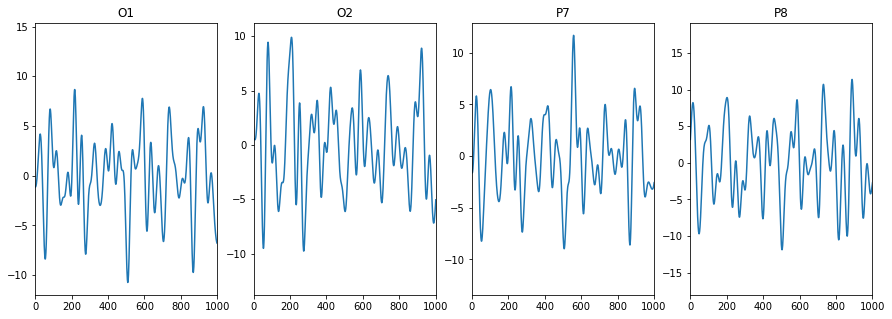

In [7]:
plot_time(templates[0])

In [8]:
# average for each same EEG.Counter number - over all stimulus cycles
averages_all_targets = []

for template in templates:
    averages_for_target = []
    o1counters = []
    o2counters = []
    p7counters = []
    p8counters = []
    for i in range(129):
        o1counters.append([])
        o2counters.append([])
        p7counters.append([])
        p8counters.append([])
        
    for ind, row in template.iterrows():
        count_val = int(row['EEG.Counter'])
        o1counters[count_val].append(row['EEG.O1'])
        o2counters[count_val].append(row['EEG.O2'])
        p7counters[count_val].append(row['EEG.P7'])
        p8counters[count_val].append(row['EEG.P8'])
    
    for i in range(129):
        # find average for each counter value
        o1avg = np.average(np.array(o1counters[i]))
        o2avg = np.average(np.array(o2counters[i]))
        p7avg = np.average(np.array(p7counters[i]))
        p8avg = np.average(np.array(p8counters[i]))
        row = {'Target': 1, 'EEG.Counter': i, 'EEG.O1': o1avg, 'EEG.O2': o2avg, 'EEG.P7': p7avg, 'EEG.P8': p8avg}
        averages_for_target.append(row)
        
    averages_all_targets.append(pd.DataFrame(data=averages_for_target))
    # 129 length averages

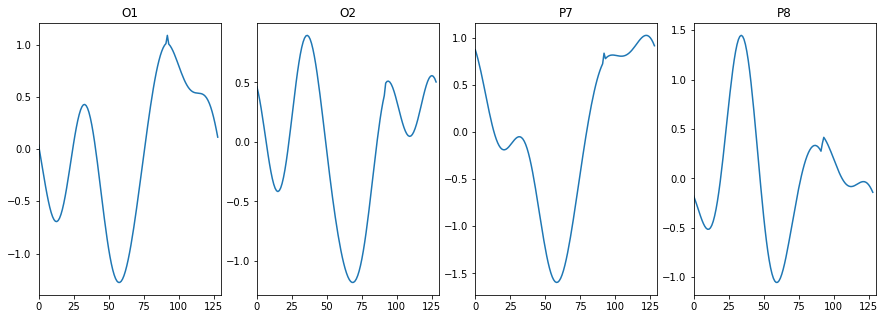

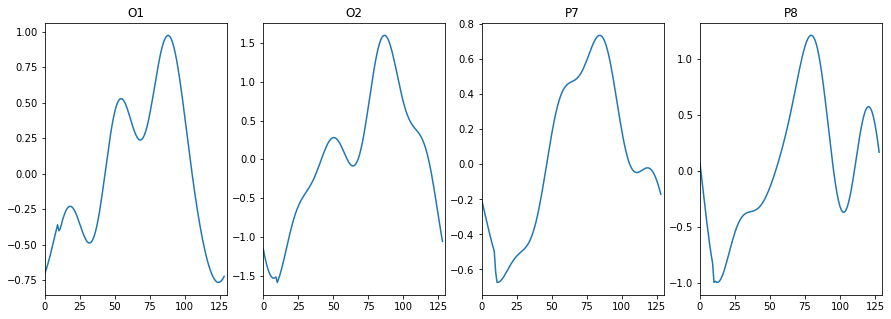

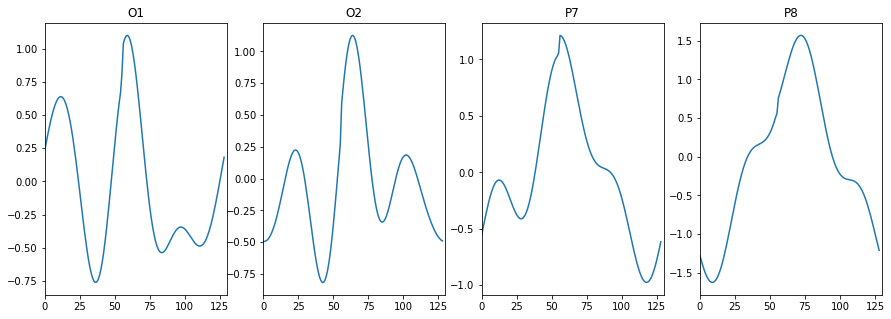

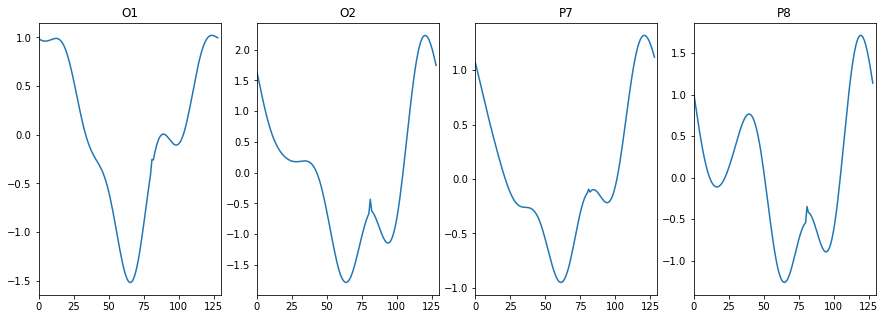

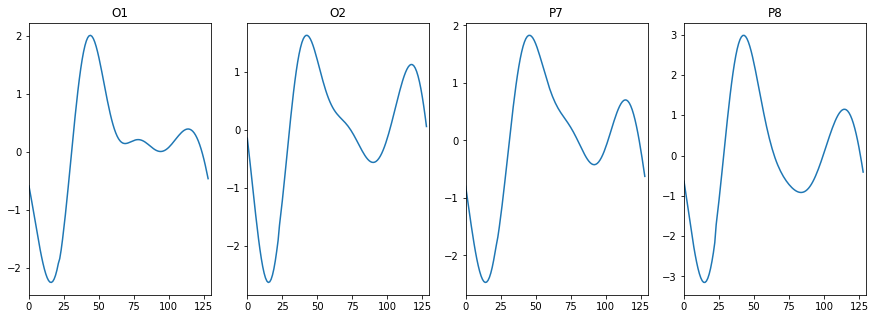

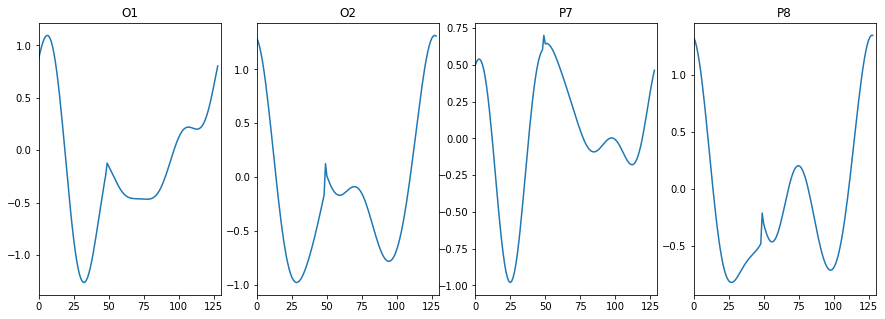

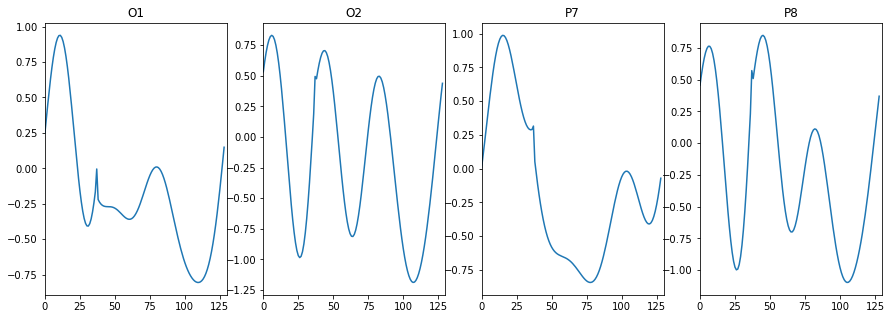

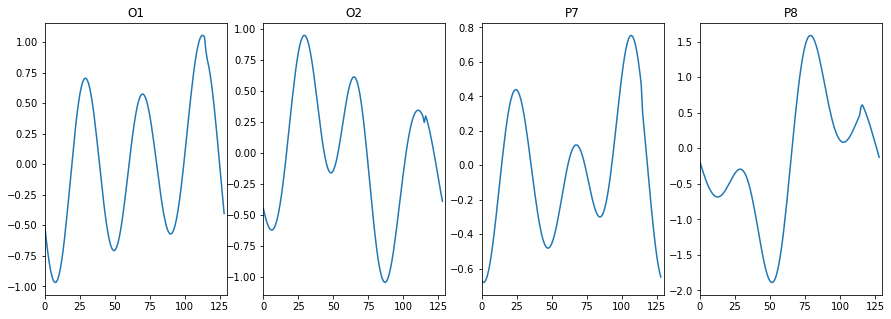

In [9]:
for sig in averages_all_targets:
    plot_time(sig, xlim=130)

In [15]:
# correlations
# take 1s - 128 samples of template[0] and correlate with each average in average_all_targets
from scipy.stats.stats import pearsonr

def signal_correlation(test_signals, verbose=False):
    # assume I have all averages
    corrs_o1 = []
    corrs_o2 = []
    corrs_p7 = []
    corrs_p8 = []
    for ref in averages_all_targets:
        # pearsonr returns r (corr value) and p-value
        corr_o1 = pearsonr(np.array(test_signals['EEG.O1']), np.array(ref['EEG.O1']))
        corr_o2 = pearsonr(np.array(test_signals['EEG.O2']), np.array(ref['EEG.O2']))
        corr_p7 = pearsonr(np.array(test_signals['EEG.P7']), np.array(ref['EEG.P7']))
        corr_p8 = pearsonr(np.array(test_signals['EEG.P8']), np.array(ref['EEG.P8']))
        corrs_o1.append(corr_o1[0])
        corrs_o2.append(corr_o2[0])
        corrs_p7.append(corr_p7[0])
        corrs_p8.append(corr_p8[0])

    targeto1 = corrs_o1.index(max(corrs_o1))
    targeto2 = corrs_o2.index(max(corrs_o2))
    targetp7 = corrs_p7.index(max(corrs_p7))
    targetp8 = corrs_p8.index(max(corrs_p8))
    
    if verbose:
        print('Correlation Data:\n{}\n{}\n{}\n{}\n'.format(corrs_o1, corrs_o2, corrs_p7, corrs_p8))

    return (targeto1, targeto2, targetp7, targetp8)


In [22]:
test1 = templates[0].query('index < 129')
# looking for target 0
to1, to2, tp7, tp8 = signal_correlation(test1)
print('targets: o1 : {}  o2 : {}   p7 : {}   p8 : {}'.format(to1, to2, tp7, tp8))

targets: o1 : 0  o2 : 1   p7 : 0   p8 : 7


In [23]:
test2 = templates[0].query('129 < index < 129*2+1')
# looking for target 0
to1, to2, tp7, tp8 = signal_correlation(test2)
print('targets: o1 : {}  o2 : {}   p7 : {}   p8 : {}'.format(to1, to2, tp7, tp8))

targets: o1 : 1  o2 : 1   p7 : 1   p8 : 2


In [24]:
test3 = templates[1].query('index < 129')
# looking for target 1 
to1, to2, tp7, tp8 = signal_correlation(test3)
print('targets: o1 : {}  o2 : {}   p7 : {}   p8 : {}'.format(to1, to2, tp7, tp8))

targets: o1 : 7  o2 : 1   p7 : 2   p8 : 6


In [27]:
test4 = templates[1].query('129 < index < 129*2+1')
# looking for target 1 
to1, to2, tp7, tp8 = signal_correlation(test4)
print('targets: o1 : {}  o2 : {}   p7 : {}   p8 : {}'.format(to1, to2, tp7, tp8))

targets: o1 : 1  o2 : 1   p7 : 1   p8 : 7


In [31]:
test5 = templates[1].query('129*2 < index < 129*3+1')
# looking for target 1 
to1, to2, tp7, tp8 = signal_correlation(test5)
print('targets: o1 : {}  o2 : {}   p7 : {}   p8 : {}'.format(to1, to2, tp7, tp8))

targets: o1 : 0  o2 : 1   p7 : 0   p8 : 4
